## Questions to ask the data:
1. What features need immediate attention for transformation? (e.g. dates, categorical, etc.)
1. Are there any features that won't be of much value predicting the target? e.g.
    - high cardinality
    - high % data missing
    - high zero count
1. Are there anomalies in some of the features? How to handle?
1. What columns have a high linear correlation to the target?
1. Are there features that can be combined or transformed?

## Understanding the Data

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# Read in the data from the .pkl
df = pd.read_pickle("./data/ingest_data.pkl")

In [3]:
df.sample(5)

,is_bad,emp_title,emp_length,home_ownership,annual_inc,verification_status,pymnt_plan,Notes,purpose_cat,purpose,...,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code
1785,0,Kit Kat Club,1,RENT,39996.0,not verified,n,I've struggled with body image issues all my l...,major purchase,In Hope of Life Changing Makeover,...,NaN,5.0,0.0,3132,78.3,8.0,f,0.0,1,PC5
9217,0,LA County Federation of Labor,1,RENT,18000.0,not verified,n,NaN,vacation,Loan,...,NaN,2.0,0.0,6892,98.5,6.0,f,0.0,3,PC4
4265,0,Wells Fargo Investments,7,MORTGAGE,168000.0,VERIFIED - income,n,Borrower added on 09/03/10 > Due to the hous...,home improvement,Finishing Basement,...,NaN,6.0,0.0,1842,73.7,19.0,f,0.0,2,PC1
8296,1,NaN,na,MORTGAGE,75156.0,VERIFIED - income source,n,Borrower added on 02/07/11 > Hi I'm a retire...,debt consolidation small business,my loan,...,NaN,11.0,0.0,39130,65.8,25.0,f,0.0,2,PC2
9655,0,Colorado School of Mines,3,MORTGAGE,32000.0,not verified,n,I am finishing up my Ph.D. in chemical enginee...,debt consolidation,Pay YOU instead of Chase & CitiBank,...,0.0,18.0,0.0,2012,100.6,23.0,f,0.0,1,PC2


In [4]:
# Split out the datetime columns into years, months, days
df.earliest_cr_line = pd.to_datetime(df.earliest_cr_line)
df['cr_line_yrs'] = df.earliest_cr_line.dt.year
df['cr_line_mths'] = df.earliest_cr_line.dt.month
df['cr_line_days'] = df.earliest_cr_line.dt.day
df.drop('earliest_cr_line', axis=1, inplace=True)

In [5]:
# List all of the column data types as they stand
df.dtypes

is_bad                          object
emp_title                       object
emp_length                      object
home_ownership                  object
annual_inc                     float64
verification_status             object
pymnt_plan                      object
Notes                           object
purpose_cat                     object
purpose                         object
zip_code                        object
addr_state                      object
debt_to_income                 float64
delinq_2yrs                    float64
inq_last_6mths                 float64
mths_since_last_delinq         float64
mths_since_last_record         float64
open_acc                       float64
pub_rec                        float64
revol_bal                        int64
revol_util                     float64
total_acc                      float64
initial_list_status             object
collections_12_mths_ex_med     float64
mths_since_last_major_derog      int64
policy_code              

Text(0, 0.5, 'data type')

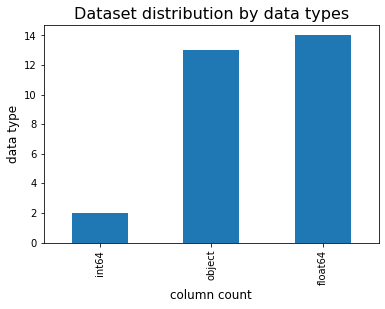

In [6]:
df.dtypes.value_counts().sort_values().plot(kind='bar')
plt.title('Dataset distribution by data types',fontsize=16)
plt.xlabel('column count',fontsize=12)
plt.ylabel('data type',fontsize=12)

In [7]:
# Need to convert 'emp_length' to a numerical column
# Any values missing or 'na' will be replaced by 0 since it makes sense that they may not have been employed a long time
def convert_num(x):
    try:
        x = int(x)
    except:
        x = 0  
    
    return x

df['emp_length'] = df.emp_length.apply(convert_num)

In [8]:
# Now list out the final numerical and categorical columns
num_cols = list(df._get_numeric_data().columns)
cat_cols = list(set(df.columns) - set(df._get_numeric_data().columns))
cat_cols.remove('is_bad')
target = ['is_bad']

In [9]:
# Make sure all categorical columns that contain text have the same case
for cat_col in cat_cols:
    df[cat_col] = df[cat_col].str.lower()

In [10]:
df.dtypes

is_bad                          object
emp_title                       object
emp_length                       int64
home_ownership                  object
annual_inc                     float64
verification_status             object
pymnt_plan                      object
Notes                           object
purpose_cat                     object
purpose                         object
zip_code                        object
addr_state                      object
debt_to_income                 float64
delinq_2yrs                    float64
inq_last_6mths                 float64
mths_since_last_delinq         float64
mths_since_last_record         float64
open_acc                       float64
pub_rec                        float64
revol_bal                        int64
revol_util                     float64
total_acc                      float64
initial_list_status             object
collections_12_mths_ex_med     float64
mths_since_last_major_derog      int64
policy_code              

In [11]:
df[cat_cols].dtypes

emp_title              object
Notes                  object
pymnt_plan             object
purpose_cat            object
zip_code               object
initial_list_status    object
purpose                object
home_ownership         object
verification_status    object
policy_code            object
addr_state             object
dtype: object

In [12]:
df[num_cols].dtypes

emp_length                       int64
annual_inc                     float64
debt_to_income                 float64
delinq_2yrs                    float64
inq_last_6mths                 float64
mths_since_last_delinq         float64
mths_since_last_record         float64
open_acc                       float64
pub_rec                        float64
revol_bal                        int64
revol_util                     float64
total_acc                      float64
collections_12_mths_ex_med     float64
mths_since_last_major_derog      int64
cr_line_yrs                    float64
cr_line_mths                   float64
cr_line_days                   float64
dtype: object

In [13]:
df[target].dtypes

is_bad    object
dtype: object

## Create an initial pandas profiling report

In [14]:
import pandas_profiling

profile_file = './lc_profile_report_initial.html'

if not os.path.exists(profile_file):    
    profile = df.profile_report(title='Initial Lending Club Data Profile Report')
    profile.to_file(output_file=profile_file)

## Baseline model for benchmarking

In [15]:
# Drop 'Notes' and 'purpose' for now, there may be useful info there to mine, but not enough time right now
try:
    df.drop(['Notes', 'purpose'], axis=1, inplace=True)
    cat_cols.remove('Notes')
    cat_cols.remove('purpose')
except:
    pass

df[cat_cols] = df[cat_cols].astype(str)
df[target] = df[target].astype(int)

# Save off the data as a checkpoint
df.to_pickle("./data/baseline_data.pkl")
df.to_csv("./data/baseline_data.csv")

# Basic label encoder to fire off a quick model (will likely be horrible)
from sklearn.preprocessing import LabelEncoder
lencoder = LabelEncoder()
lencoded = df[cat_cols].apply(lencoder.fit_transform)

enc_df = df[num_cols+target].join(lencoded)
enc_df.head()

enc_df.to_pickle("./data/enc_baseline_data.pkl")
enc_df.to_csv("./data/enc_baseline_data.csv")

In [16]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split

enc_df = enc_df.sort_values(['cr_line_yrs', 'cr_line_mths'])
validation_perc = 0.1
validation_size = int(len(enc_df) * validation_perc)

train = enc_df[:-2 * validation_size]
valid = enc_df[-2 * validation_size:-validation_size]
test = enc_df[-validation_size:]

feature_cols = train.columns.drop('is_bad')

dtrain = lgb.Dataset(train[feature_cols], label=train['is_bad'])
dvalid = lgb.Dataset(valid[feature_cols], label=valid['is_bad'])

param = {'num_leaves': 32, 'objective': 'binary'}
param['metric'] = 'auc'
num_round = 1000
bst = lgb.train(param, dtrain, num_round, valid_sets=[dvalid], early_stopping_rounds=10, verbose_eval=False)

In [17]:
from sklearn import metrics
ypred = bst.predict(test[feature_cols])
score = metrics.roc_auc_score(test['is_bad'], ypred)

print(f"Test AUC score: {score}")
print(metrics.classification_report(test['is_bad'].tolist(), np.around(ypred, decimals=0)))

print("Min accuracy to beat for just random guessing in the TEST set:")
print(len(test[test.is_bad == 0])/len(test))

Test AUC score: 0.6005448663374766
              precision    recall  f1-score   support

           0       0.85      1.00      0.92       839
           1       0.85      0.07      0.13       161

    accuracy                           0.85      1000
   macro avg       0.85      0.53      0.52      1000
weighted avg       0.85      0.85      0.79      1000

Min accuracy to beat for just random guessing in the TEST set:
0.839


In [18]:
# See target distribution amongst the datasets
print("TRAIN:")
print(train.is_bad.describe())
print()
print("VALIDATION:")
print(valid.is_bad.describe())
print()
print("TEST:")
print(test.is_bad.describe())

TRAIN:
count    8000.000000
mean        0.127000
std         0.332994
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: is_bad, dtype: float64

VALIDATION:
count    1000.00000
mean        0.11800
std         0.32277
min         0.00000
25%         0.00000
50%         0.00000
75%         0.00000
max         1.00000
Name: is_bad, dtype: float64

TEST:
count    1000.000000
mean        0.161000
std         0.367715
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: is_bad, dtype: float64


In [19]:
enc_df.query('emp_length > 10 and is_bad == 1')

,emp_length,annual_inc,debt_to_income,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,...,is_bad,emp_title,pymnt_plan,purpose_cat,zip_code,initial_list_status,home_ownership,verification_status,policy_code,addr_state
897,33,100800.0,17.83,0.0,2.0,NaN,NaN,6.0,0.0,10065,...,1,2644,0,5,614,0,4,2,2,3
438,22,100000.0,17.88,2.0,1.0,19.0,NaN,11.0,0.0,13654,...,1,3184,0,8,351,0,0,0,1,34
1114,11,39804.0,9.50,1.0,2.0,16.0,NaN,9.0,0.0,1309,...,1,7085,0,5,536,0,4,1,3,35
699,22,67200.0,13.54,7.0,1.0,16.0,94.0,9.0,1.0,820,...,1,4082,0,21,650,0,4,2,4,4
801,11,91992.0,20.30,0.0,2.0,NaN,NaN,12.0,0.0,42813,...,1,6594,0,8,261,0,0,2,4,10
959,22,40800.0,16.06,0.0,1.0,NaN,NaN,6.0,0.0,4159,...,1,2913,0,16,656,0,3,0,0,4
708,22,31243.0,5.03,0.0,1.0,NaN,NaN,5.0,0.0,2988,...,1,6247,0,0,76,0,3,0,4,33
3808,22,32000.0,9.38,0.0,2.0,NaN,NaN,9.0,0.0,5532,...,1,3043,0,18,690,0,4,2,0,4


### Basic Feature Engineering

In [20]:
# Drop or fill features with % missing
df.drop('emp_title', axis=1, inplace=True)

In [21]:
df['delinq_2yrs'] = df.delinq_2yrs.fillna(0)

def make_bin(x):
    if int(x) > 0:
        return '1'
    else:
        return '0'

df['delinq_2yrs_bin'] = df.delinq_2yrs.apply(make_bin)

In [22]:
df['inq_last_6mths'].fillna(0, inplace=True)
df['inq_last_6mths_bin'] = df.inq_last_6mths.apply(make_bin)

In [23]:
df['mths_since_last_delinq'].fillna(0, inplace=True)

In [24]:
df['mths_since_last_record'].max()
df['mths_since_last_record'].fillna(df.mths_since_last_record.max(), inplace=True)
df['mths_since_last_record'] = df['mths_since_last_record'].astype(int)

In [25]:
df['pub_rec'].fillna(0, inplace=True)
df['pub_rec'] = df['pub_rec'].astype(int)

In [26]:
df.drop('cr_line_days', axis=1, inplace=True)

In [27]:
pd.options.mode.use_inf_as_na = True
df['cr_line_mths'].fillna(df.cr_line_mths.mode()[0], inplace=True)  # 10.0 is the mode of the data
#df['cr_line_mths'].unique()
df['cr_line_mths'] = df['cr_line_mths'].astype(int)

In [28]:
df.drop('collections_12_mths_ex_med', axis=1, inplace=True)

In [29]:
# Save out the data with basic feature engineering
df.to_pickle("./data/fe_data.pkl")
df.to_csv("./data/fe_data.csv")

### Basic Feature Engineered Profile Report

In [30]:
profile_file = './lc_profile_report_bfe.html'

override = False
if not os.path.exists(profile_file) or override:    
    profile = df.profile_report(title='Basic Featured Engineered Lending Club Data Profile Report')
    profile.to_file(output_file=profile_file)

## EDA

In [31]:
corr = df.corr()['is_bad'].sort_values()

# Display correlations
print('Most Positive Correlations with "is_bad"')
print(20*"-")
print(corr.tail(10))
print()
print('Most Negative Correlations with "is_bad"')
print(20*"-")
print(corr.head(10))

Most Positive Correlations with "is_bad"
--------------------
inq_last_6mths                -0.001007
mths_since_last_delinq         0.014576
mths_since_last_record         0.014978
mths_since_last_major_derog    0.015481
delinq_2yrs                    0.021897
cr_line_yrs                    0.029591
debt_to_income                 0.029873
pub_rec                        0.032218
revol_util                     0.087876
is_bad                         1.000000
Name: is_bad, dtype: float64

Most Negative Correlations with "is_bad"
--------------------
total_acc                     -0.055307
annual_inc                    -0.050975
cr_line_mths                  -0.035356
emp_length                    -0.026845
open_acc                      -0.020356
revol_bal                     -0.016202
inq_last_6mths                -0.001007
mths_since_last_delinq         0.014576
mths_since_last_record         0.014978
mths_since_last_major_derog    0.015481
Name: is_bad, dtype: float64


In [69]:
corr = df.corr()['debt_to_income'].sort_values()

# Display correlations
print('Most Positive Correlations with "dti"')
print(20*"-")
print(corr.tail(10))
print()
print('Most Negative Correlations with "dti"')
print(20*"-")
print(corr.head(10))

Most Positive Correlations with "dti"
--------------------
cr_line_mths             -0.002689
inq_last_6mths            0.013220
is_bad                    0.029873
mths_since_last_record    0.043172
emp_length                0.061412
revol_bal                 0.163794
total_acc                 0.233594
revol_util                0.271439
open_acc                  0.301003
debt_to_income            1.000000
Name: debt_to_income, dtype: float64

Most Negative Correlations with "dti"
--------------------
annual_inc                    -0.130184
cr_line_yrs                   -0.054521
delinq_2yrs                   -0.034213
mths_since_last_delinq        -0.017424
mths_since_last_major_derog   -0.007031
pub_rec                       -0.005214
cr_line_mths                  -0.002689
inq_last_6mths                 0.013220
is_bad                         0.029873
mths_since_last_record         0.043172
Name: debt_to_income, dtype: float64


In [42]:
df.delinq_2yrs.dtype

dtype('float64')

emp_length
annual_inc
debt_to_income
delinq_2yrs
Selected KDE bandwidth is 0. Cannot estimate density.
inq_last_6mths
mths_since_last_delinq
mths_since_last_record
Selected KDE bandwidth is 0. Cannot estimate density.
open_acc
pub_rec
Selected KDE bandwidth is 0. Cannot estimate density.
revol_bal
revol_util
total_acc
mths_since_last_major_derog
cr_line_yrs
cr_line_mths


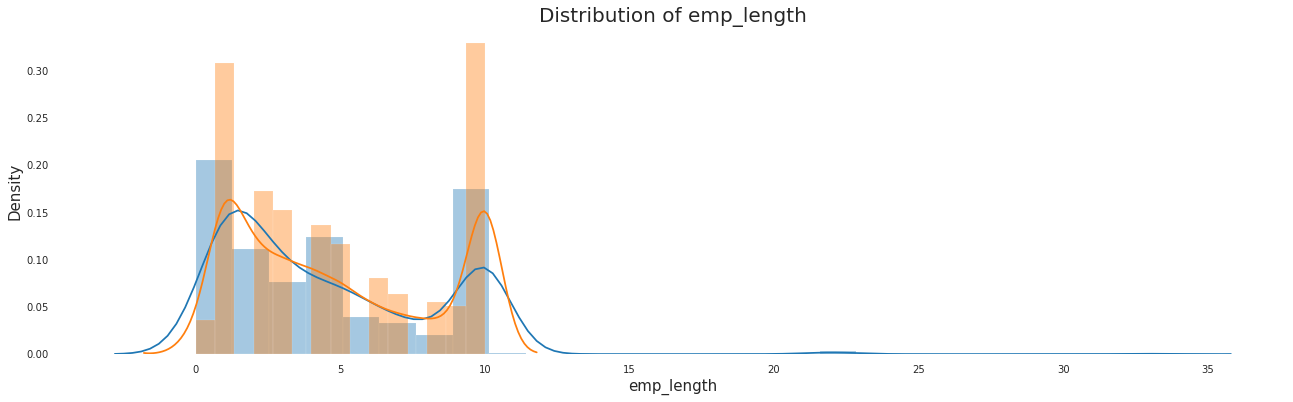

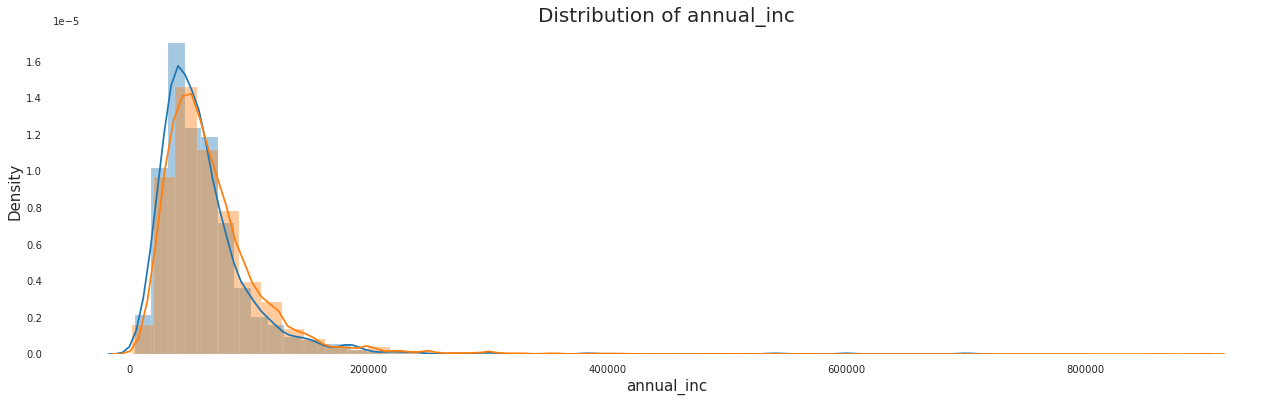

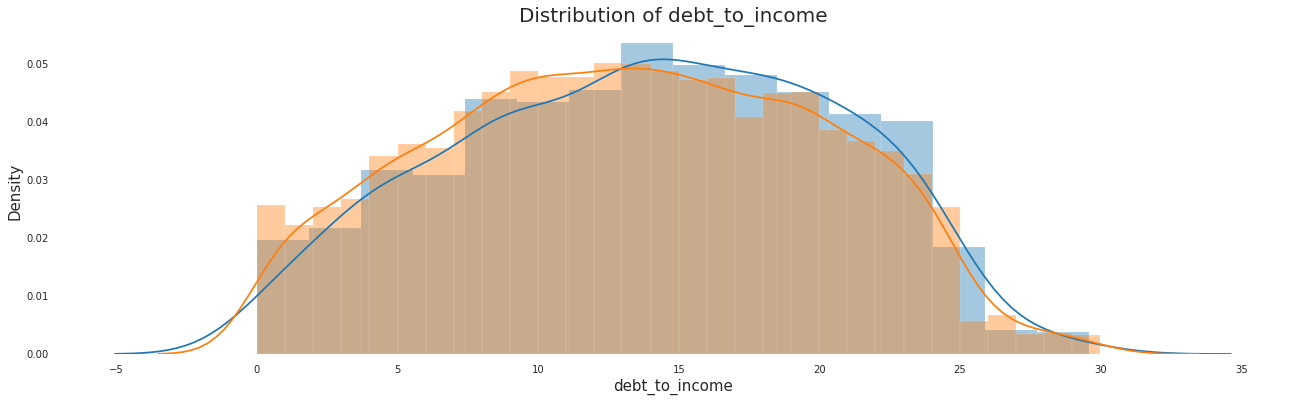

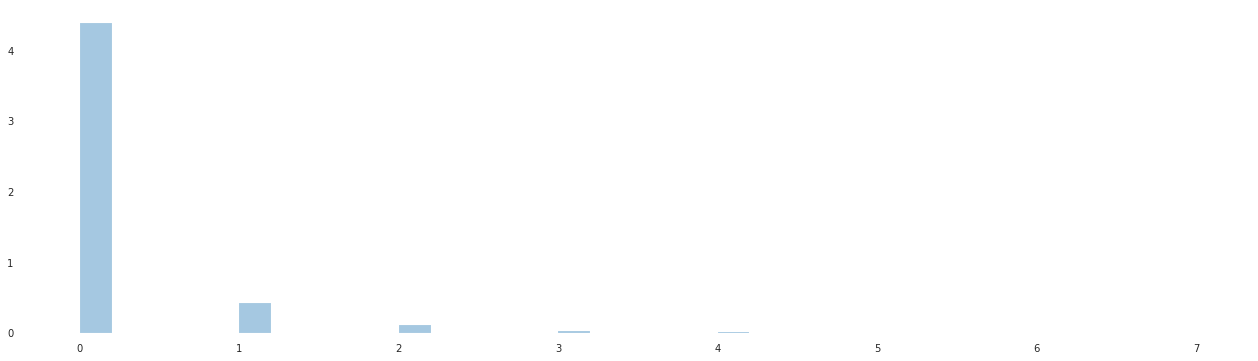

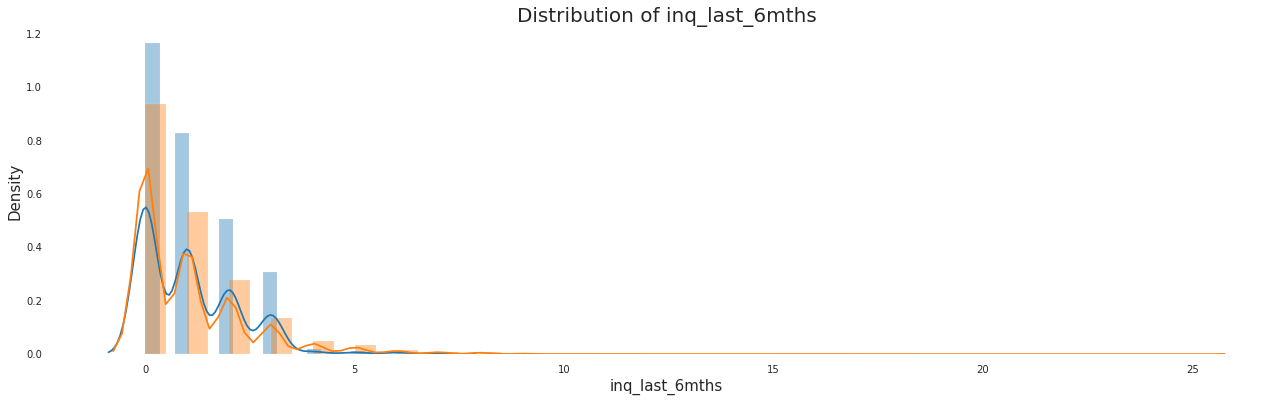

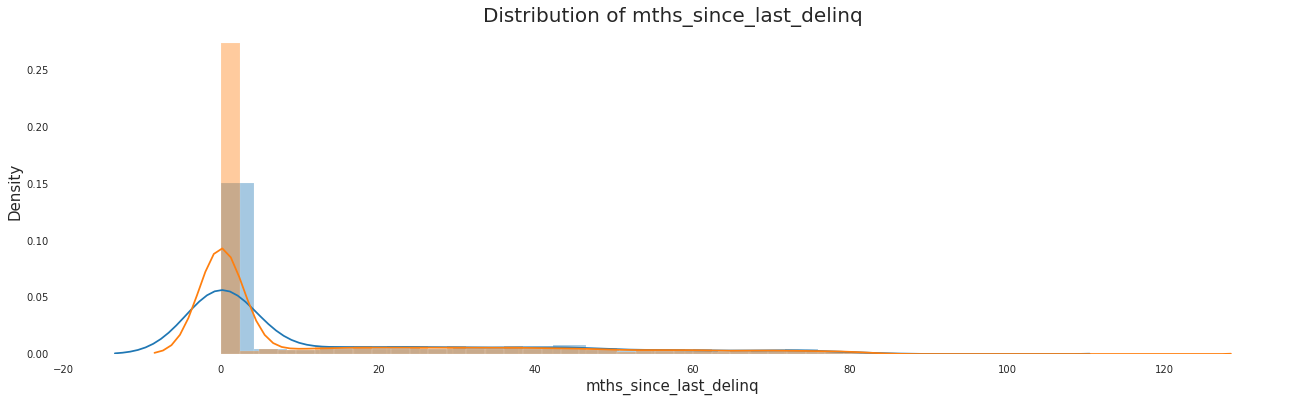

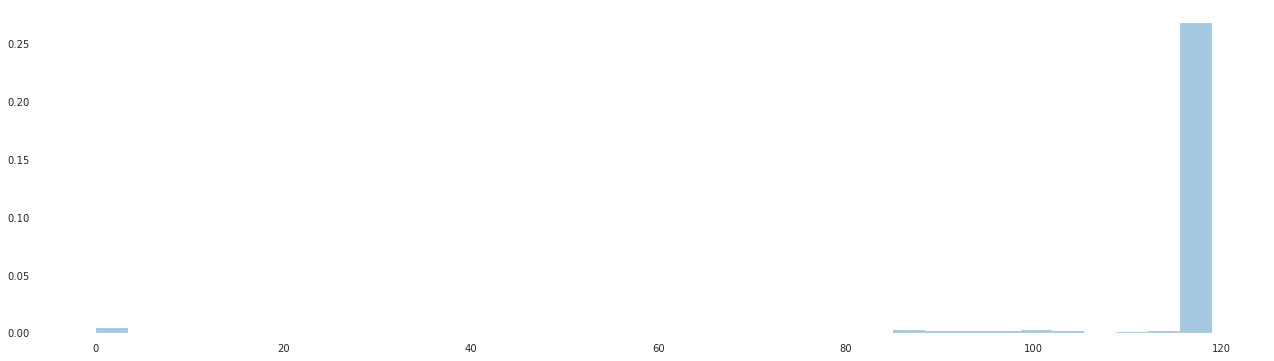

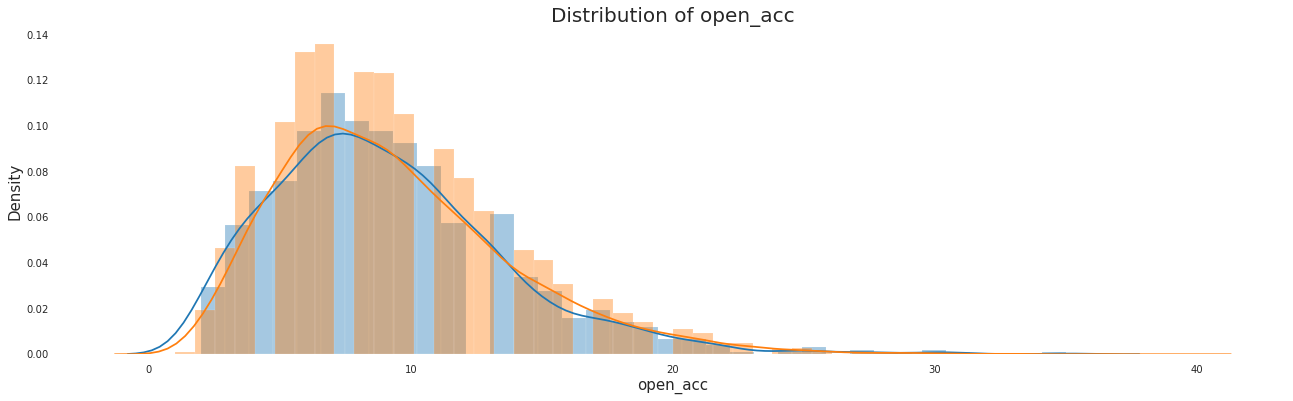

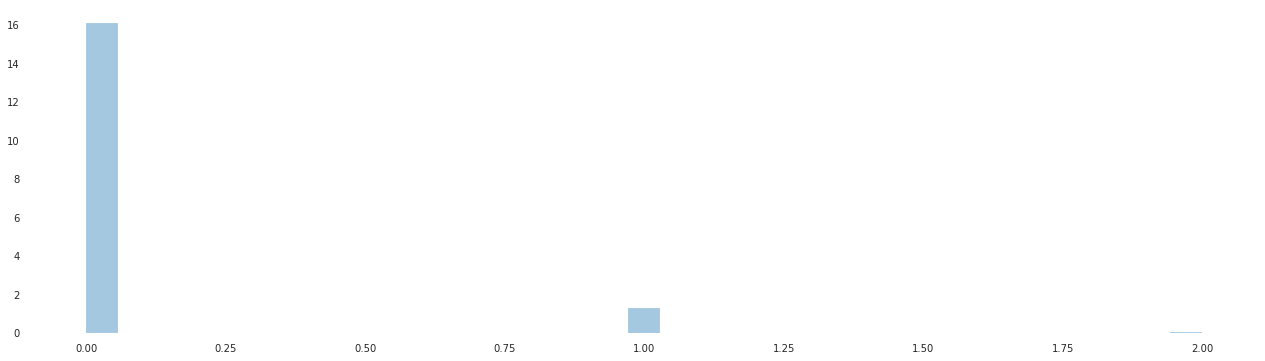

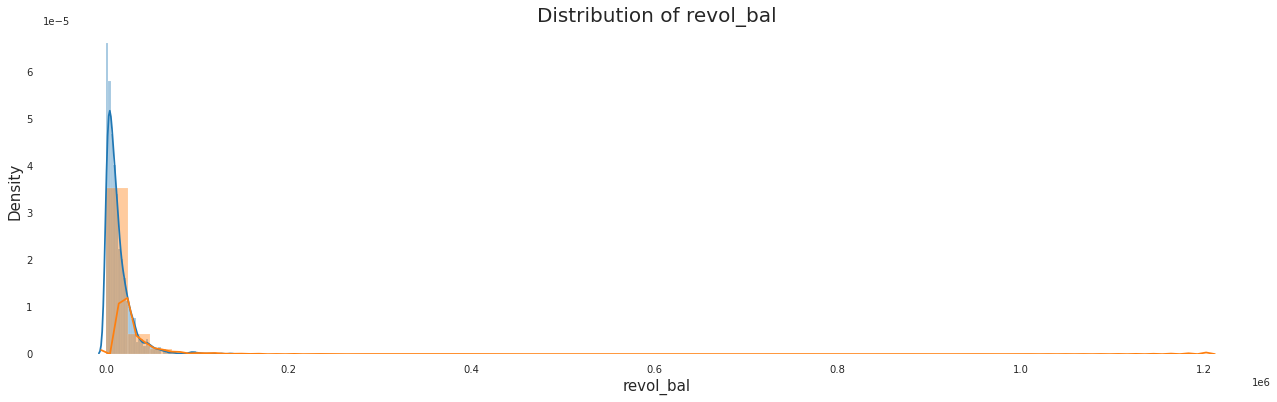

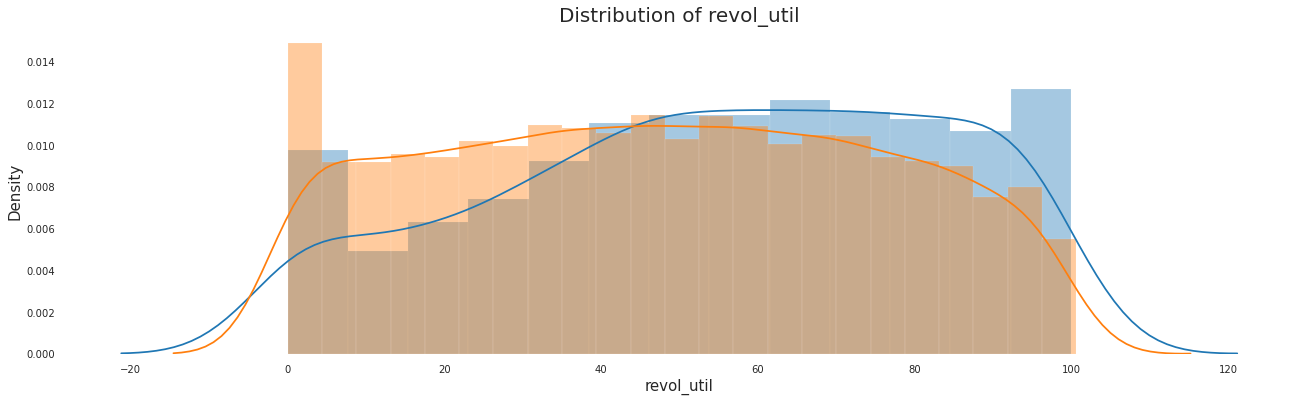

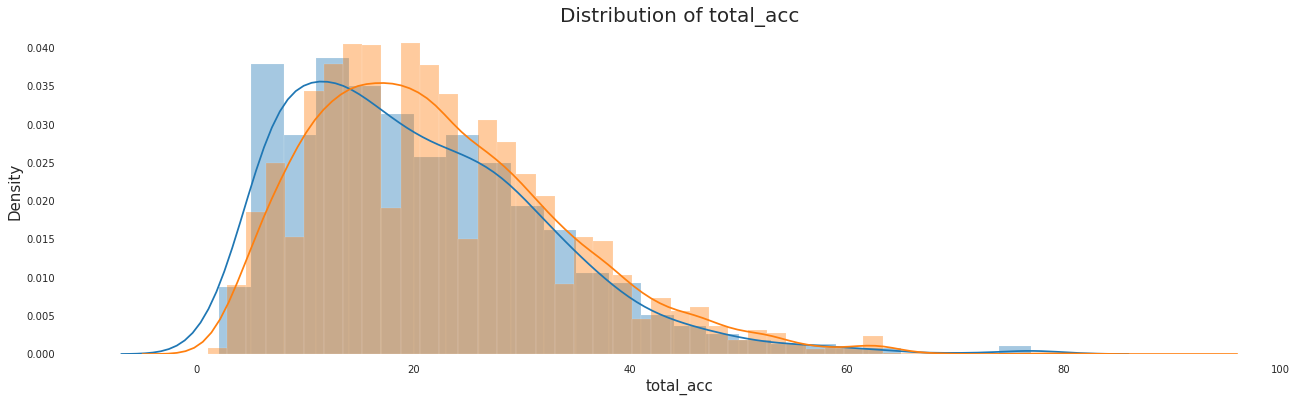

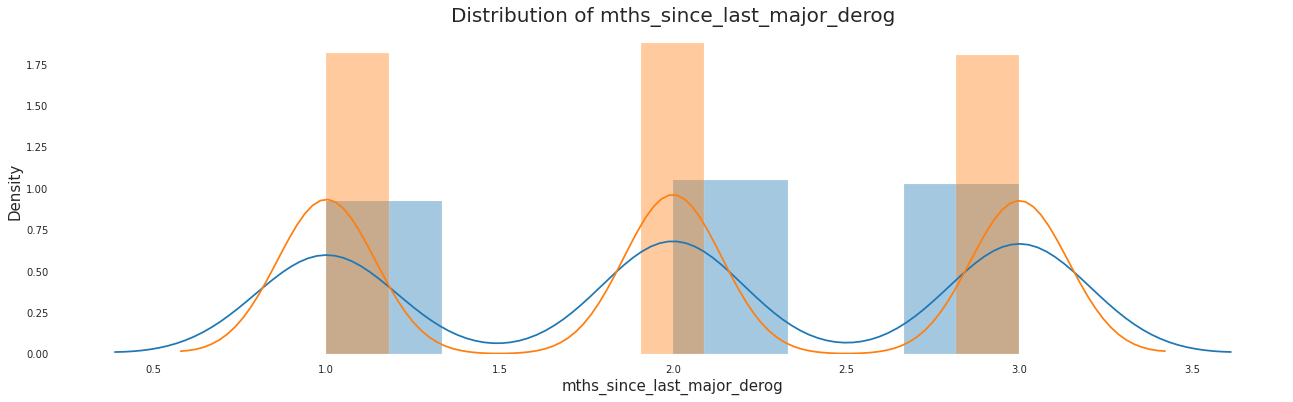

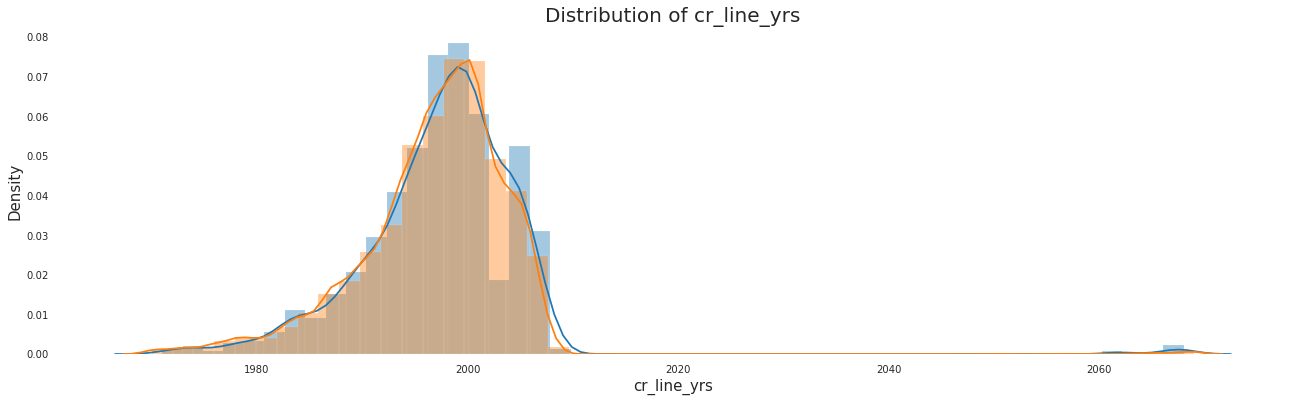

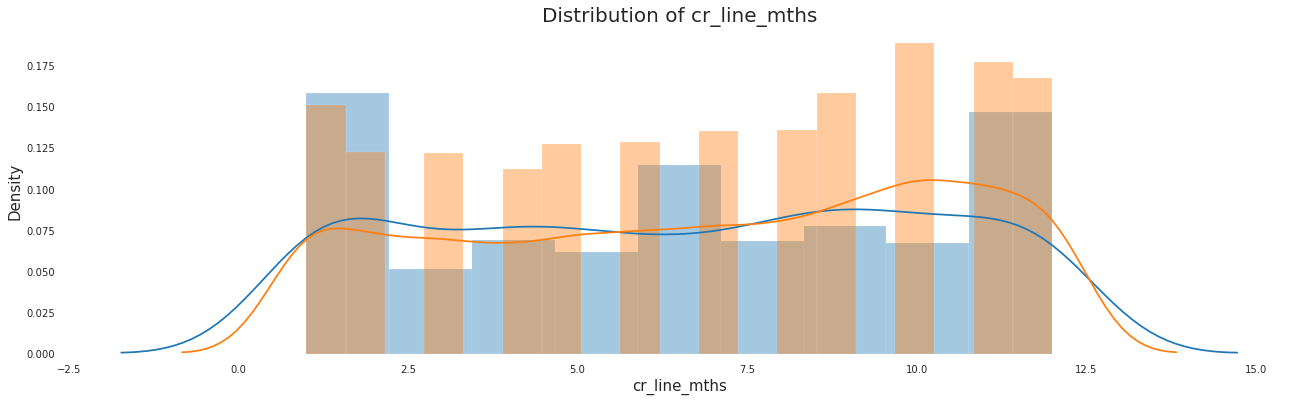

In [73]:
import seaborn as sns

# Plot out the dist plots + kde
def plot_dist(df, param):
    #param = 'debt_to_income'
    fig = plt.figure(figsize=(22,6))
    sns.distplot(df.loc[df['is_bad'] == 1, param], label = 'is_bad = 1')
    sns.distplot(df.loc[df['is_bad'] == 0, param], label = 'is_bad = 0')
    plt.xlabel(param ,fontsize=15)
    plt.ylabel('Density',fontsize=15)
    plt.title('Distribution of {}'.format(param), fontsize=20)
    
    return fig


for param in df._get_numeric_data().columns:
    if param != 'is_bad':
        print(param)
        try:
            fig = plot_dist(df, param)
        except Exception as e:
            print(e)
            del fig

emp_length
annual_inc
debt_to_income
delinq_2yrs
inq_last_6mths
mths_since_last_delinq
mths_since_last_record
open_acc
pub_rec
revol_bal
revol_util
total_acc
mths_since_last_major_derog
cr_line_yrs
cr_line_mths


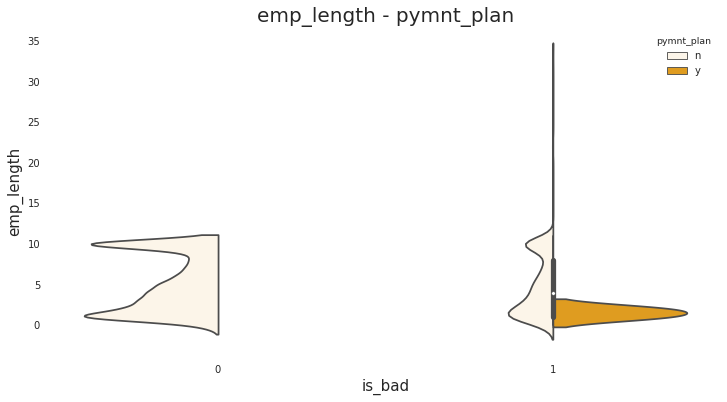

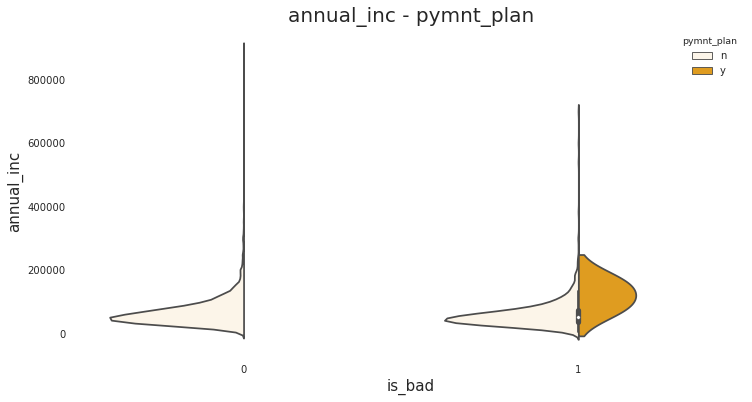

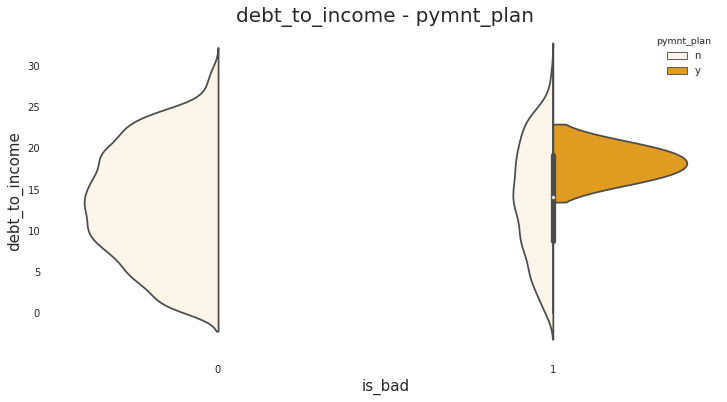

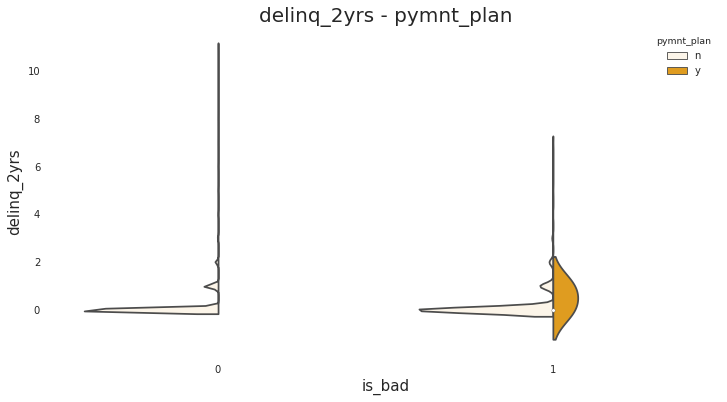

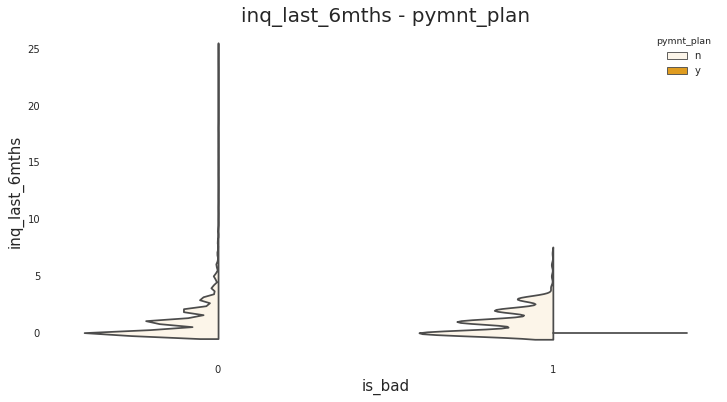

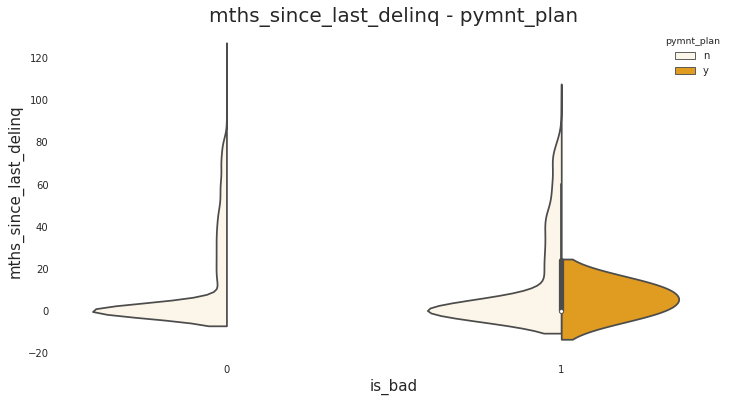

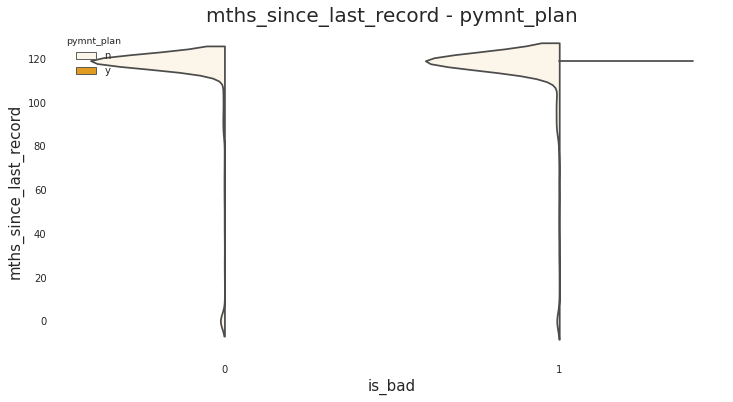

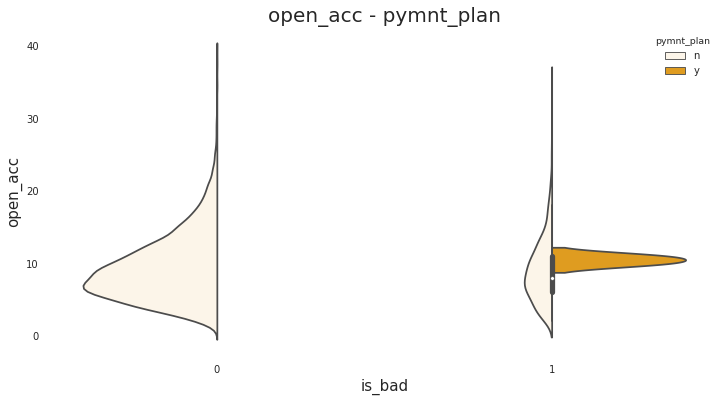

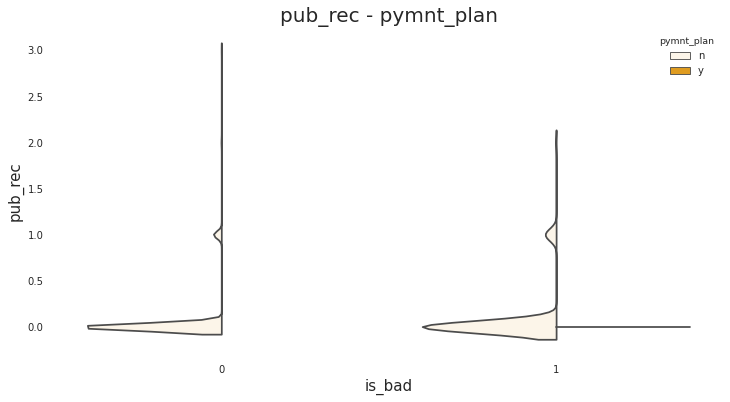

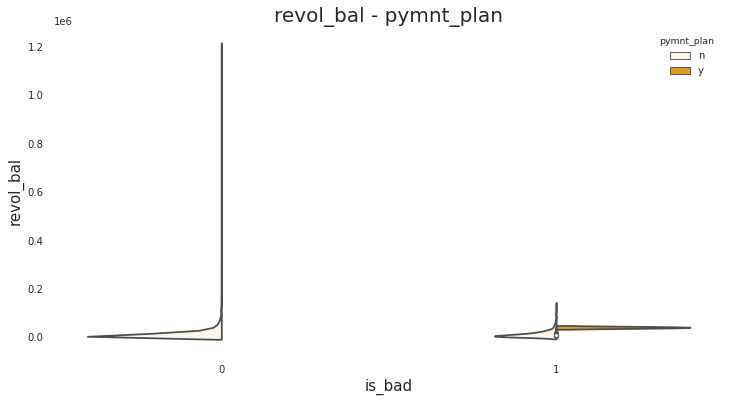

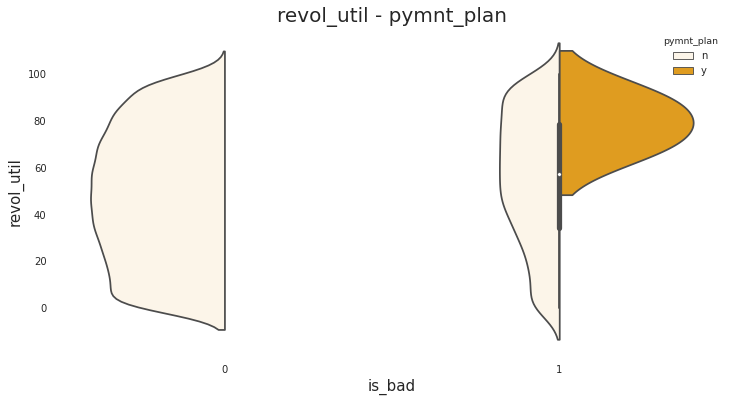

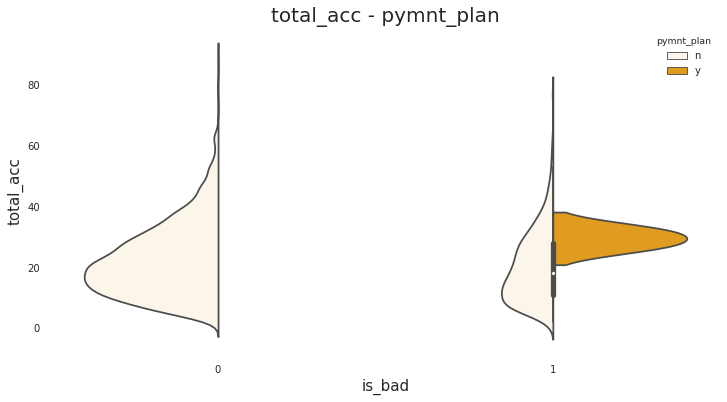

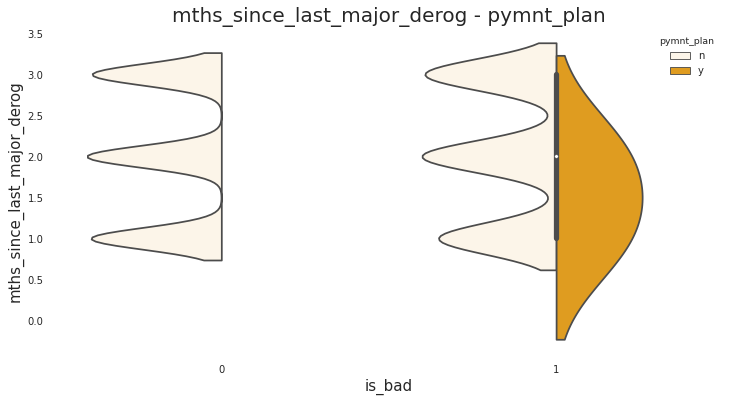

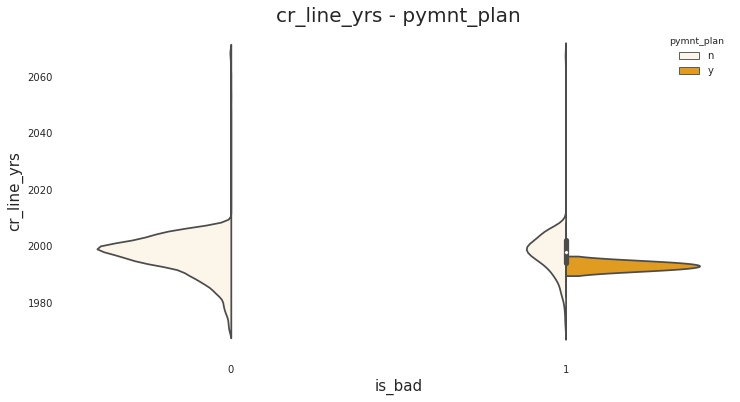

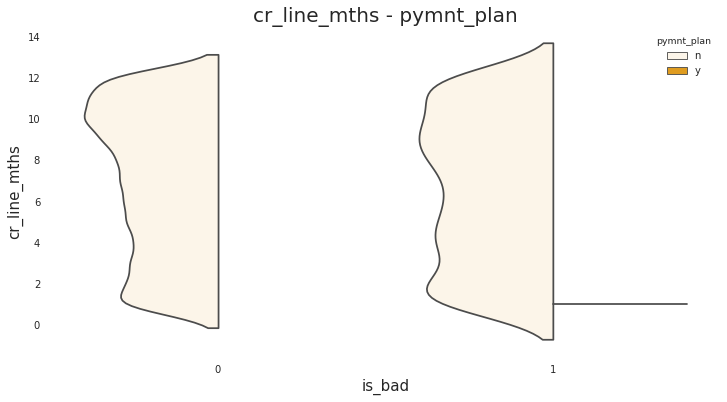

In [68]:
# Plot out some violin plots

def plot_violin(df, param1, param2):
    fig = plt.figure(figsize=(12,6))
    sns.violinplot(x="is_bad", y=param1, data=df, hue=param2, split=True, color='orange')
    plt.title("{0} - {1}".format(param1, param2), fontsize=20)
    plt.xlabel("is_bad", fontsize=15)
    plt.ylabel(param1, fontsize=15)

bin_param = ['pymnt_plan', 'delinq_2yrs_bin', 'inq_last_6mths_bin']
param2 = bin_param[0]
for param1 in df._get_numeric_data().columns:
        if param1 != 'is_bad':
            print(param1)
            try:
                plot_violin(df, param1, param2)
            except Exception as e:
                print(e)